In [1]:
import os
import xarray as xr
import random 
import numpy as np
from sklearn.metrics import mean_squared_error


# pytorch
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Eurac utils
from hython.hython.datasets.dataset_reader import xarray_to_array, create_dataset
from hython.hython.models.lstm import CustomLSTMModel
from hython.hython.train_val import train_val

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import xarray as xr
import random 
import numpy as np
from sklearn.metrics import mean_squared_error


# pytorch
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Eurac utils
from hython.hython.datasets.dataset_reader import xarray_to_array, create_dataset
from hython.hython.models.lstm import CustomLSTMModel
from hython.hython.train_val import train_val

import warnings
warnings.filterwarnings("ignore")
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)
import glob 
glob.glob('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data')
dyn_vars_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Dynamic_Data_2000_2015.nc',decode_coords='all')#.to_dataset(dim='variable')
static_params_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/staticmaps.nc',decode_coords='all')#.to_dataset(dim='variable')
target_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Target_train_et_sm_2000_2015.nc',decode_coords='all')
#Exp6 
stat_parmas = ['wflow_dem','Slope','Sl', 'Swood','N','N_River','wflow_landuse','KsatHorFrac','SoilThickness',
               'SoilMinThickness','MaxLeakage','PathFrac','wflow_glacierstore','wflow_glacierfrac','rootdistpar',
               'wflow_riverlength','RiverSlope','wflow_riverwidth', 'RootingDepth', 'thetaS','thetaR','KsatVer', 
               'SoilThickness', 'f', 'M_', 'Kext','c','cf_soil','Cfmax','EoverR','TT','TTI','TTM','WHC','G_Cfmax',
               'G_TT','G_SIfrac','WaterFrac','WHC','InfiltCapPath','InfiltCapSoil',  'wflow_glacierareas',
               'wflow_glacierstore','wflow_glacierfrac', 'ResMaxVolume','ResTargetFullFrac','ResTargetMinFrac']


dyn_vars_ds1 = dyn_vars_ds.sel(time=slice(dyn_vars_ds.time[1462], dyn_vars_ds.time[4382]))
target_ds1 = target_ds.sel(time=slice(target_ds.time[1462], target_ds.time[4382]))
# Create the dataset and return DataLoader
train_loader, val_loader  = create_dataset(dyn_vars_ds1, static_params_ds, target_ds1,
                                           batch_size=8,
                                           time_steps=2921, #time_steps=365 5844
                                           dyn_vars_names=['precip', 'pet', 'temp'],
                                           static_params_names=stat_parmas, #[ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'],
                                           target_names=['soil_moisture', 'evapotranspiration']) # ['vwc_percroot', 'soil_moisture']
# Invistigate the dataset 
for x1, x2, y in train_loader:
    print(x1.shape)
    print(x2.shape)
    print(y.shape)
    break
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        
        self.mseloss = nn.MSELoss()

    def forward(self, y_true, y_pred):
        """
        Calculate the Root Mean Squared Error (RMSE) between two tensors.

        Parameters:
        y_true (torch.Tensor): The true values.
        y_pred (torch.Tensor): The predicted values.

        Returns:
        torch.Tensor: The RMSE loss.
        """
        rmse_loss = torch.sqrt(self.mseloss(y_true, y_pred))

        return rmse_loss
model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": 256, # user_input
    "output_size": 2, # number_target - user_input
    "number_static_predictors": 50, #number of static parameters - user_input 

}


## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CustomLSTMModel(model_params)
model = model.to(device)
model
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output[:,:,0], target[:,:,0], squared=False)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5)

## Set the training parameters
params_train={
    "num_epochs": 150,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"

}

model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

In [3]:
import glob 
glob.glob('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data')

['/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data']

In [4]:
dyn_vars_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Dynamic_Data_2000_2015.nc',decode_coords='all')#.to_dataset(dim='variable')
static_params_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/staticmaps.nc',decode_coords='all')#.to_dataset(dim='variable')
target_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Target_train_et_sm_2000_2015.nc',decode_coords='all')

In [5]:
target_ds

<xarray.Dataset>
Dimensions:             (lon: 245, lat: 214, time: 5844)
Coordinates:
  * lon                 (lon) float64 10.29 10.3 10.3 10.31 ... 12.3 12.31 12.32
  * lat                 (lat) float64 45.31 45.32 45.33 ... 47.07 47.08 47.09
  * time                (time) datetime64[ns] 2000-01-01 ... 2015-12-31
Data variables:
    soil_moisture       (time, lat, lon) float32 ...
    evapotranspiration  (time, lat, lon) float32 ...

In [6]:

static_params_ds

<xarray.Dataset>
Dimensions:               (lat: 214, lon: 245, time: 12, layer: 4)
Coordinates:
  * lat                   (lat) float64 47.09 47.08 47.07 ... 45.33 45.32 45.31
  * lon                   (lon) float64 10.29 10.3 10.3 ... 12.3 12.31 12.32
  * time                  (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * layer                 (layer) int64 0 1 2 3
    spatial_ref           int32 ...
Data variables: (12/76)
    x_out                 (lat, lon) float64 ...
    y_out                 (lat, lon) float64 ...
    idx_out               (lat, lon) float64 ...
    wflow_ldd             (lat, lon) float32 ...
    wflow_subcatch        (lat, lon) float64 ...
    wflow_uparea          (lat, lon) float32 ...
    ...                    ...
    TTM                   (lat, lon) float32 ...
    WHC                   (lat, lon) float32 ...
    G_Cfmax               (lat, lon) float32 ...
    G_SIfrac              (lat, lon) float32 ...
    G_TT                  (lat, lon) float32 ...
    wflow_gauges_eurac    (lat, lon) float64 ...

In [7]:
#Exp1
#stat_parmas = ['KsatVer_0.0cm', 'wflow_dem']
#Exp 2
#stat_parmas = ['dem_subgrid','Slope', 'wflow_dem','Sl', 'Swood','N','wflow_landuse',
#             'RootingDepth', 'thetaS','thetaR','KsatVer', 'SoilThickness', 'f', 'M_original', 'Kext']
#Exp 3
#stat_parmas = ['dem_subgrid','Slope', 'wflow_dem','Sl', 'Swood','N','wflow_landuse','KsatHorFrac','SoilThickness','SoilMinThickness',
#               'RootingDepth', 'thetaS','thetaR','KsatVer', 'SoilThickness', 'f', 'M_', 'Kext','c','cf_soil','Cfmax','EoverR']
#Exp4
#stat_parmas = ['dem_subgrid','Slope', 'wflow_dem','Sl', 'Swood','N','wflow_landuse','KsatHorFrac',
                #'SoilThickness','SoilMinThickness','MaxLeakage','PathFrac', 'RootingDepth', 'thetaS','thetaR','KsatVer',
#               'SoilThickness', 'f', 'M_', 'Kext','c','cf_soil','Cfmax','EoverR','TT','TTI','TTM','WHC',
#               'G_Cfmax','G_TT','G_SIfrac','WaterFrac','WHC','InfiltCapPath','InfiltCapSoil']
#Exp5
#stat_parmas = ['wflow_dem','Slope','Sl', 'Swood','N','wflow_landuse','KsatHorFrac','SoilThickness',
#                'MaxLeakage','PathFrac','wflow_glacierstore','wflow_glacierfrac','rootdistpar','SoilMinThickness',
#               'RootingDepth', 'thetaS','thetaR','KsatVer', 'SoilThickness', 'f', 'M_', 'Kext','c','cf_soil',
#                'Cfmax','EoverR','TT','TTI','TTM','WHC','G_Cfmax','G_TT','G_SIfrac','WaterFrac','WHC',
#                'InfiltCapPath','InfiltCapSoil']
#Exp6 
stat_parmas = ['wflow_dem','Slope','Sl', 'Swood','N','N_River','wflow_landuse','KsatHorFrac','SoilThickness',
               'SoilMinThickness','MaxLeakage','PathFrac','wflow_glacierstore','wflow_glacierfrac','rootdistpar',
               'wflow_riverlength','RiverSlope','wflow_riverwidth', 'RootingDepth', 'thetaS','thetaR','KsatVer', 
               'SoilThickness', 'f', 'M_', 'Kext','c','cf_soil','Cfmax','EoverR','TT','TTI','TTM','WHC','G_Cfmax',
               'G_TT','G_SIfrac','WaterFrac','WHC','InfiltCapPath','InfiltCapSoil' ,'wflow_glacierareas',
               'wflow_glacierstore','wflow_glacierfrac', 'ResMaxVolume','ResTargetFullFrac','ResTargetMinFrac']


dyn_vars_ds1 = dyn_vars_ds.sel(time=slice(dyn_vars_ds.time[1462], dyn_vars_ds.time[4382]))
target_ds1 = target_ds.sel(time=slice(target_ds.time[1462], target_ds.time[4382]))


In [8]:
# Create the dataset and return DataLoader
train_loader, val_loader  = create_dataset(dyn_vars_ds1, static_params_ds, target_ds1,
                                           batch_size=8,
                                           time_steps=2921, #time_steps=365 5844
                                           dyn_vars_names=['precip', 'pet', 'temp'],
                                           static_params_names=stat_parmas, #[ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'],
                                           target_names=['soil_moisture', 'evapotranspiration']) # ['vwc_percroot', 'soil_moisture']

(52430, 2921, 2)
Done target parmas
(52430, 2921, 3)
Done dynamics parmas
(52430, 50)
Done static parmas
0
0
0


In [9]:
# Invistigate the dataset 
for x1, x2, y in train_loader:
    print(x1.shape)
    print(x2.shape)
    print(y.shape)
    break

torch.Size([8, 2921, 3])
torch.Size([8, 50])
torch.Size([8, 2921, 2])


In [10]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        
        self.mseloss = nn.MSELoss()

    def forward(self, y_true, y_pred):
        """
        Calculate the Root Mean Squared Error (RMSE) between two tensors.

        Parameters:
        y_true (torch.Tensor): The true values.
        y_pred (torch.Tensor): The predicted values.

        Returns:
        torch.Tensor: The RMSE loss.
        """
        rmse_loss = torch.sqrt(self.mseloss(y_true, y_pred))

        return rmse_loss

In [11]:
model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": 256, # user_input
    "output_size": 2, # number_target - user_input
    "number_static_predictors": 50, #number of static parameters - user_input 

}


## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CustomLSTMModel(model_params)
model = model.to(device)
model

CustomLSTMModel(
  (lstm): LSTM(3, 256, batch_first=True)
  (fc1): Linear(in_features=306, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

### Soil Moisture 

In [12]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output[:,:,0], target[:,:,0], squared=False)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5)

## Set the training parameters
params_train={
    "num_epochs": 150,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"

}

model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/149, current lr=0.01
Copied best model weights!
train loss: 6167372289.876406, train metric: 71846.046875
val loss: 1610.6792808424293, val metric: 56.29114532470703
----------
Epoch 1/149, current lr=0.01
train loss: 3208.1543844608295, train metric: 79.79154968261719
val loss: 176237.3749376714, val metric: 592.5411376953125
----------
Epoch 2/149, current lr=0.01
Copied best model weights!
train loss: 21164483.73241242, train metric: 6497.9033203125
val loss: 322.8474357488951, val metric: 24.47789192199707
----------
Epoch 3/149, current lr=0.01
train loss: 2469472.5609215447, train metric: 2215.198486328125
val loss: 32651.206175205683, val metric: 253.25094604492188
----------
Epoch 4/149, current lr=0.01
train loss: 741130.6258594617, train metric: 1091.371826171875
val loss: 5098.164496121993, val metric: 97.62879943847656
----------
Epoch 5/149, current lr=0.01
Copied best model weights!
train loss: 97011.47873935082, train metric: 424.134033203125
val loss: 189.156747

train loss: 620.9743852781834, train metric: 35.09082794189453
val loss: 276.5796959134475, val metric: 23.064714431762695
----------
Epoch 49/149, current lr=0.00015625
Loading best model weights!
train loss: 577.0403490822808, train metric: 33.81940460205078
val loss: 1332.1989311193533, val metric: 51.39869689941406
----------
Epoch 50/149, current lr=7.8125e-05
train loss: 445.7249417901931, train metric: 29.638437271118164
val loss: 191.47801167790772, val metric: 19.195817947387695
----------
Epoch 51/149, current lr=7.8125e-05
Copied best model weights!
train loss: 369.7774736532844, train metric: 27.035154342651367
val loss: 128.6500734164215, val metric: 15.768933296203613
----------
Epoch 52/149, current lr=7.8125e-05
train loss: 382.2330473845142, train metric: 27.50541114807129
val loss: 366.5170604294002, val metric: 26.684370040893555
----------
Epoch 53/149, current lr=7.8125e-05
train loss: 365.24800490952487, train metric: 26.894519805908203
val loss: 161.4323033722996

KeyboardInterrupt: 

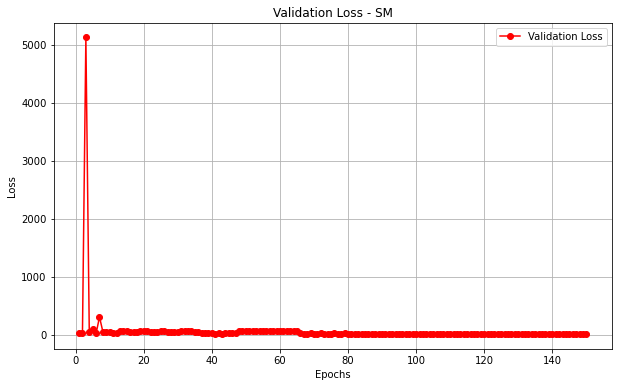

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the loss values
train_loss = sm_metric_history['train']
val_loss = sm_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
epochs = list(range(1, 151))

# Create a DataFrame to store validation loss data
loss_df = pd.DataFrame({'Epochs': epochs, 'Validation Loss': val_loss})

# Save the DataFrame to a CSV file
loss_df.to_csv('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/SM_Exp8.csv', index=False)

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/SM_EXP8.png', bbox_inches='tight', dpi=300)
plt.show()


### ET

In [36]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output[:,:,1], target[:,:,1], squared=False)
    return metric_epoch


# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5)

## Set the training parameters
params_train={
    "num_epochs": 150,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"

}

model, et_loss_history ,et_metric_history = train_val(model, params_train)

Epoch 0/149, current lr=0.01
Copied best model weights!
train loss: 1239.7358315788897, train metric: 1.1606600284576416
val loss: 897.0950500518716, val metric: 1.1543056964874268
----------
Epoch 1/149, current lr=0.01
Copied best model weights!
train loss: 621.0004944152071, train metric: 1.148268222808838
val loss: 451.20903413440186, val metric: 1.1475549936294556
----------
Epoch 2/149, current lr=0.01
Copied best model weights!
train loss: 325.79767234212443, train metric: 1.1482763290405273
val loss: 271.63523034091247, val metric: 1.148559808731079
----------
Epoch 3/149, current lr=0.01
Copied best model weights!
train loss: 235.05876924319756, train metric: 1.1481375694274902
val loss: 236.20590601416782, val metric: 1.145713448524475
----------
Epoch 4/149, current lr=0.01
Copied best model weights!
train loss: 224.42017827592883, train metric: 1.148180365562439
val loss: 234.37188766734377, val metric: 1.148437261581421
----------
Epoch 5/149, current lr=0.01
Copied best m

train loss: 224.1669403742079, train metric: 1.148024082183838
val loss: 234.23234541747254, val metric: 1.14956796169281
----------
Epoch 48/149, current lr=0.00015625
train loss: 224.1665078826676, train metric: 1.1478490829467773
val loss: 234.23431914240842, val metric: 1.1495736837387085
----------
Epoch 49/149, current lr=0.00015625
train loss: 224.1661645294722, train metric: 1.1478619575500488
val loss: 234.23617541917807, val metric: 1.1495604515075684
----------
Epoch 50/149, current lr=0.00015625
Loading best model weights!
train loss: 224.16589815896052, train metric: 1.1480233669281006
val loss: 234.2386445240676, val metric: 1.149106502532959
----------
Epoch 51/149, current lr=7.8125e-05
Copied best model weights!
train loss: 224.16858253193615, train metric: 1.1538244485855103
val loss: 234.22617655649236, val metric: 1.1524221897125244
----------
Epoch 52/149, current lr=7.8125e-05
train loss: 224.16764056426925, train metric: 1.1499115228652954
val loss: 234.227382575

Copied best model weights!
train loss: 224.16755917327956, train metric: 1.149590253829956
val loss: 234.22606136804208, val metric: 1.1509428024291992
----------
Epoch 92/149, current lr=1.220703125e-06
Copied best model weights!
Loading best model weights!
train loss: 224.1675579308869, train metric: 1.149560809135437
val loss: 234.22606091533805, val metric: 1.150913953781128
----------
Epoch 93/149, current lr=6.103515625e-07
Copied best model weights!
train loss: 224.16755620523583, train metric: 1.149538516998291
val loss: 234.22605903604565, val metric: 1.1509000062942505
----------
Epoch 94/149, current lr=6.103515625e-07
train loss: 224.16755505036238, train metric: 1.1495234966278076
val loss: 234.22605919582355, val metric: 1.1508855819702148
----------
Epoch 95/149, current lr=6.103515625e-07
Copied best model weights!
train loss: 224.16755406672223, train metric: 1.1495088338851929
val loss: 234.22605842736795, val metric: 1.1508723497390747
----------
Epoch 96/149, curren

train loss: 224.16754721929308, train metric: 1.149409294128418
val loss: 234.22605469160857, val metric: 1.1507799625396729
----------
Epoch 135/149, current lr=1.9073486328125e-08
train loss: 224.16754713177383, train metric: 1.149409294128418
val loss: 234.22605469160857, val metric: 1.1507799625396729
----------
Epoch 136/149, current lr=1.9073486328125e-08
train loss: 224.16754722309827, train metric: 1.149409294128418
val loss: 234.22605469160857, val metric: 1.1507799625396729
----------
Epoch 137/149, current lr=1.9073486328125e-08
train loss: 224.16754731442268, train metric: 1.149409294128418
val loss: 234.22605469160857, val metric: 1.1507799625396729
----------
Epoch 138/149, current lr=1.9073486328125e-08
train loss: 224.16754735057194, train metric: 1.149409294128418
val loss: 234.22605469160857, val metric: 1.1507799625396729
----------
Epoch 139/149, current lr=1.9073486328125e-08
train loss: 224.16754747043524, train metric: 1.149409294128418
val loss: 234.226054691608

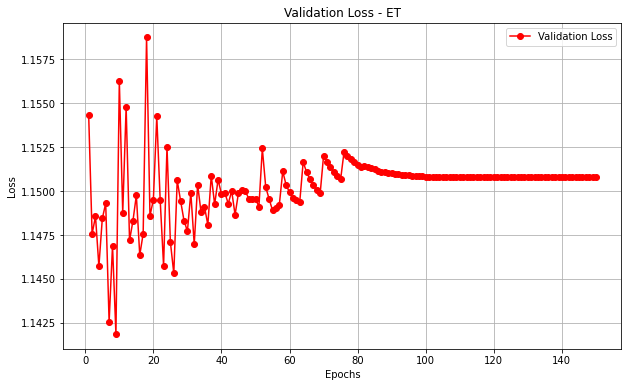

In [37]:
import matplotlib.pyplot as plt

# Extract the loss values
train_loss = et_metric_history['train']
val_loss = et_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
epochs = list(range(1, 151))

# Create a DataFrame to store validation loss data
loss_df = pd.DataFrame({'Epochs': epochs, 'Validation Loss': val_loss})

# Save the DataFrame to a CSV file
loss_df.to_csv('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/ET_Exp8.csv', index=False)

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
#plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - ET')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/ET_EXP8.png', bbox_inches='tight', dpi=300)
plt.show()